In [1]:
import pandas as pd
import river
from pprint import pprint
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
import itertools
import datetime as dt
from river import ensemble
from river import stream
from river import datasets
from river import facto
from river import compat
from river import tree
from river import neighbors
from river import multioutput
from river import neural_net
from river import dummy
from river import compat
from river import time_series
import numpy as np
import time
from tqdm import tqdm
%matplotlib inline

In [31]:
dati_test = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/HouseTwenty/HouseTwenty_TEST.txt", delim_whitespace=True, header=None)

dati_train = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/HouseTwenty/HouseTwenty_TRAIN.txt", delim_whitespace=True, header=None)

dati_train = dati_train.drop(0, axis= 1)
dati_test = dati_test.drop(0, axis= 1)

dati_train = dati_train.stack().reset_index()
dati_test = dati_test.stack().reset_index()

dati_train = dati_train.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_train = dati_train[['Count_days','Tick','PowerConsumption']]

dati_test = dati_test.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_test = dati_test[['Count_days','Tick','PowerConsumption']]


# concateno i due dataset almeno per quanto riguarda lo sviluppo di algoritmi online

dati_complete = pd.concat([dati_train,dati_test])

dati_complete = dati_complete[['Count_days', 'Tick','PowerConsumption' ]]
dati_complete.to_csv('dati_PowerConsumption_twe')


dati_complete = pd.read_csv('/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerConsumption_twe')



dati_complete = dati_complete[['Count_days', 'Tick','PowerConsumption' ]]
dati_complete


def initial_iter():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerConsumption_twe'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'PowerConsumption': float,
                     'Tick': int
                     },
              target='PowerConsumption'
                      )
       return X_y

In [24]:
dati_complete

,Count_days,Tick,PowerConsumption
0,0,1,349.0
1,0,2,349.0
2,0,3,347.0
3,0,4,351.0
4,0,5,347.0
...,...,...,...
317995,118,1996,274.0
317996,118,1997,272.0
317997,118,1998,274.0
317998,118,1999,274.0


In [130]:
dati_test.PowerConsumption.isna().sum()

0

<AxesSubplot:>

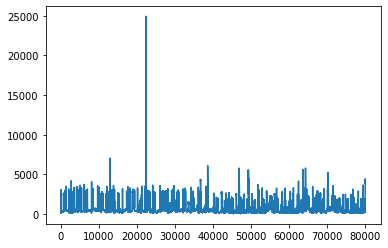

In [136]:

dati_train.PowerConsumption.plot()

In [132]:
dati_test.PowerConsumption.isna().sum()

0

<AxesSubplot:>

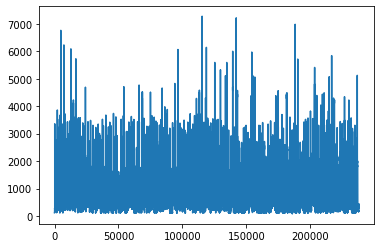

In [133]:
dati_test.PowerConsumption.plot()

<AxesSubplot:>

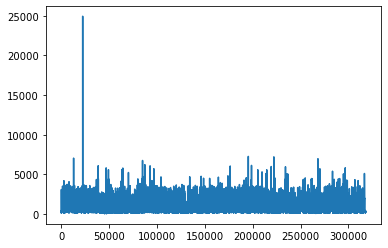

In [26]:
dati_complete.PowerConsumption.plot()

In [39]:
X_y = initial_iter()
next(X_y)

({'': '0', 'Count_days': 0, 'Tick': 1}, 349.0)

In [41]:
dati_complete.shape[0]

318000

100%|██████████| 318000/318000 [00:10<00:00, 30258.33it/s]
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 10.511586666107178 seconds
0. Input
--------
: 237999 (str)
Count_days: 118 (int)
Tick: 2000 (int)

1. ['Count_days', 'Tick']
-------------------------
Count_days: 118 (int)
Tick: 2000 (int)

2. StandardScaler
-----------------
Count_days: 1.98145 (float)
Tick: 1.73118 (float)

3. LinearRegression
-------------------
Name         Value      Weight       Contribution  
Count_days    1.98145    378.61830      750.21144  
 Intercept    1.00000   -199.96982     -199.96982  
      Tick    1.73118   -143.92531     -249.16133  

Prediction: 301.08028


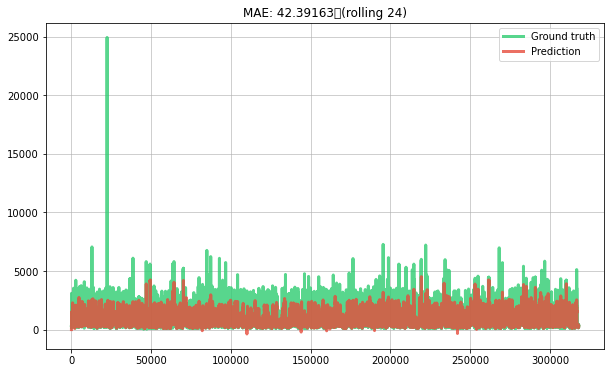

In [92]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'Count_days','Tick')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))


# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in range(0,290000):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in range(290000,318000):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(model.debug_one(x))

100%|██████████| 318000/318000 [00:10<00:00, 31065.36it/s]
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 10.238783597946167 seconds


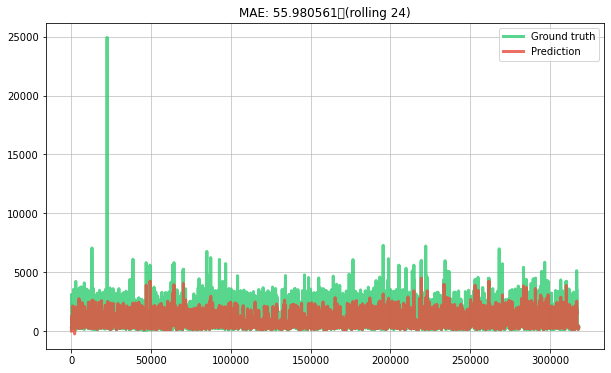

In [89]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'Count_days')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))


# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,290000)):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#        metric.update(y, y_pred)
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in tqdm(range(290000,318000)):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

100%|██████████| 10000/10000 [00:00<00:00, 23712.63it/s]

Execution time: 0.42427825927734375 seconds


AttributeError: 'Pipeline' object has no attribute 'loss_'

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


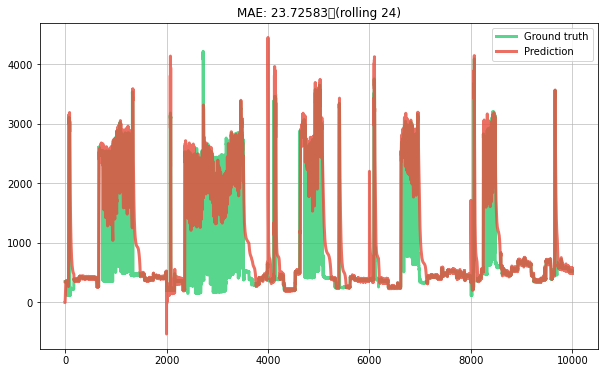

In [99]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'Count_days','Tick')
model |= preprocessing.StandardScaler()
model |= linear_model.PARegressor.(
       C=0.01,
       mode=2,
       eps=0.1,
       learn_intercept=False
)



# get the start time
st = time.time()

for i in tqdm(range(0,10000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,290000)):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in tqdm(range(290000,318000)):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(model.loss_)

100%|██████████| 318000/318000 [02:59<00:00, 1773.09it/s]
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 179.349369764328 seconds


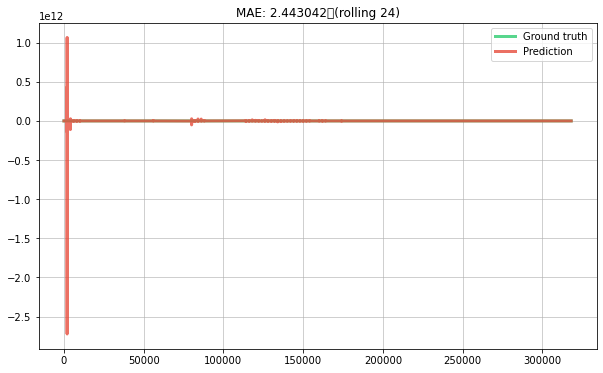

In [57]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'Count_days','Tick')
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(
       n_models=3,
       grace_period=20,
       max_depth=20
)


# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,290000)):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in tqdm(range(290000,318000)):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Text(0.5, 1.0, 'MAE: 54.572834\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


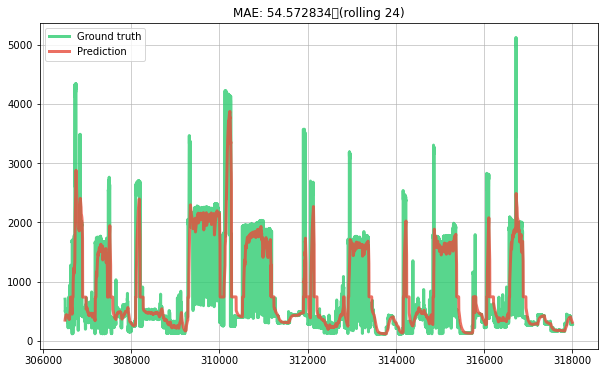

In [88]:
ax.set_title(metric) #318000
ax.set_title(metric)
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[306500::], y_trues[306500::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[306500::], y_preds[306500::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

100%|██████████| 318000/318000 [06:34<00:00, 805.82it/s] 
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 394.62912011146545 seconds


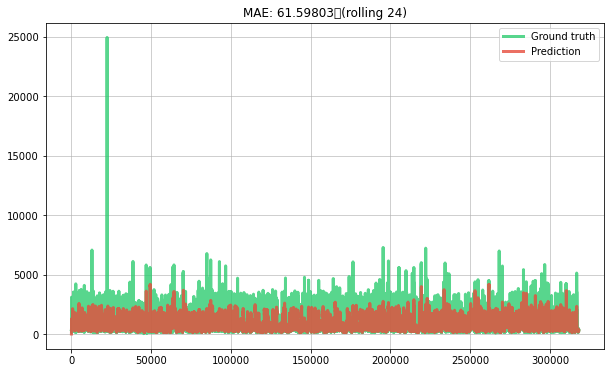

In [64]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(5, 10),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD()
       )
)


# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,290000)):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in tqdm(range(290000,318000)):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 394.62912011146545 seconds


Text(0.5, 1.0, 'MAE: 61.59803\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


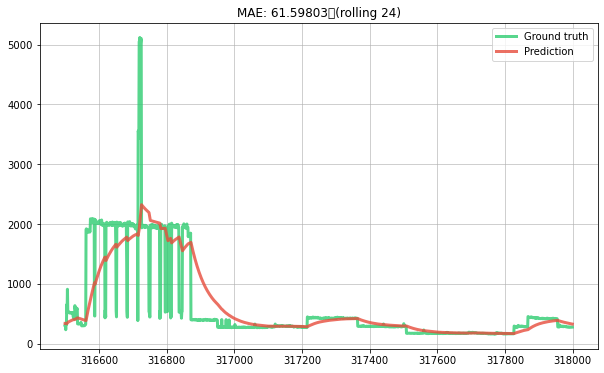

In [65]:
print('Execution time:', elapsed_time, 'seconds')
ax.set_title(metric)  #318000
ax.set_title(metric)
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[316500::], y_trues[316500::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[316500::], y_preds[316500::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

100%|██████████| 318000/318000 [00:14<00:00, 21430.71it/s]
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 14.84048080444336 seconds


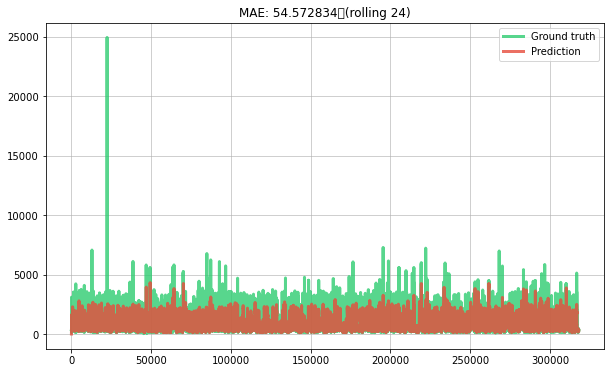

In [86]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( )
model |= tree.HoeffdingAdaptiveTreeRegressor(
       grace_period=20,
       leaf_prediction='adaptive',
       min_samples_split=30
       )


# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,290000)):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in tqdm(range(290000,318000)):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 14.84048080444336 seconds
Execution time: 14.84048080444336 seconds


Text(0.5, 1.0, 'MAE: 54.572834\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


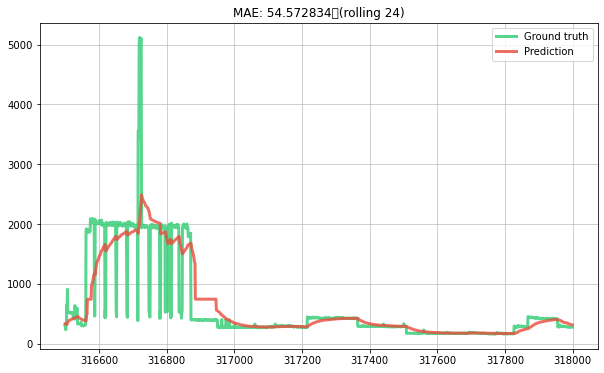

In [87]:
print('Execution time:', elapsed_time, 'seconds')
print('Execution time:', elapsed_time, 'seconds')
ax.set_title(metric)  #318000
ax.set_title(metric)
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[316500::], y_trues[316500::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[316500::], y_preds[316500::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

100%|██████████| 318000/318000 [02:36<00:00, 2029.23it/s]
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 156.71180272102356 seconds


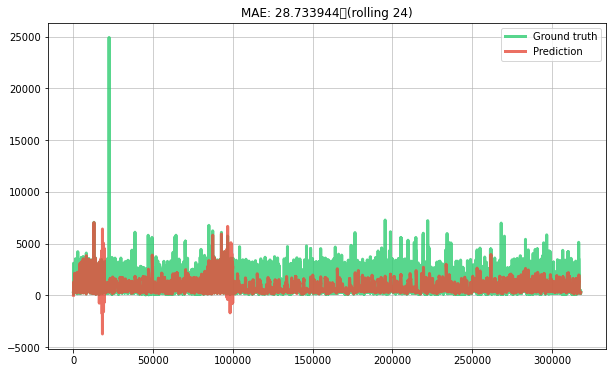

In [83]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'Count_days')
model |= tree.HoeffdingTreeRegressor(
       leaf_prediction='adaptive'
)

# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,290000)):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in tqdm(range(290000,318000)):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 156.71180272102356 seconds
Execution time: 156.71180272102356 seconds
Execution time: 156.71180272102356 seconds


Text(0.5, 1.0, 'MAE: 28.733944\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


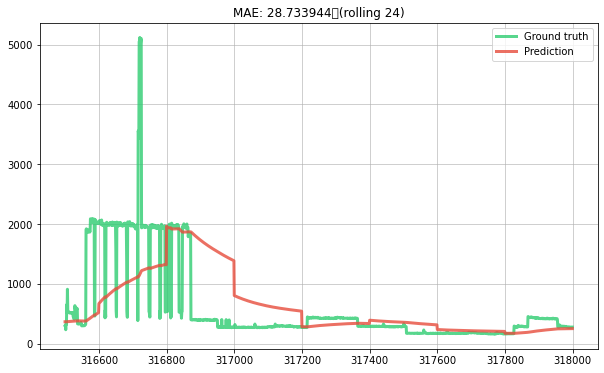

In [84]:
print('Execution time:', elapsed_time, 'seconds')
print('Execution time:', elapsed_time, 'seconds')
print('Execution time:', elapsed_time, 'seconds')
ax.set_title(metric)  #318000
ax.set_title(metric)
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[316500::], y_trues[316500::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[316500::], y_preds[316500::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

100%|██████████| 318000/318000 [00:42<00:00, 7440.06it/s]
/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Execution time: 42.743831634521484 seconds


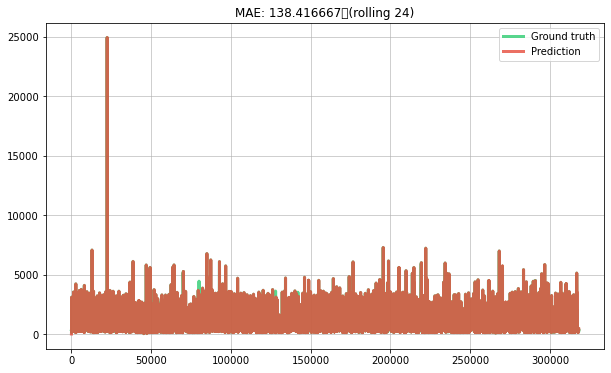

In [90]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 24)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( 'Count_days')
model |= neighbors.KNNRegressor(
       window_size= 50,
       n_neighbors=5
)

# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(i)
       y_trues.append(y)
       y_preds.append(y_pred)

# for i in tqdm(range(0,290000)):  #318000
#        x, y = next(X_y)
#        # Obtain the prior prediction and update the model in one go
#
#        y_pred = model.predict_one(x)
#        model.learn_one(x, y)
#
#        # Update the error metric
#
#
#        # Store the true value and the prediction
#        dates.append(i)
#        y_trues.append(y)
#        y_preds.append(y_pred)
#
#        if i == 289999:
#               for i in tqdm(range(290000,318000)):
#                      x, y = next(X_y)
#                      y_pred = model.predict_one(x)
#                      model.learn_one(x, y_pred)
#                      metric.update(y, y_pred)
#                      dates.append(i)
#                      y_trues.append(y)
#                      y_preds.append(y_pred)

# get the end time
et = time.time()


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 42.743831634521484 seconds
Execution time: 42.743831634521484 seconds
Execution time: 42.743831634521484 seconds


Text(0.5, 1.0, 'MAE: 138.416667\t(rolling 24)')

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


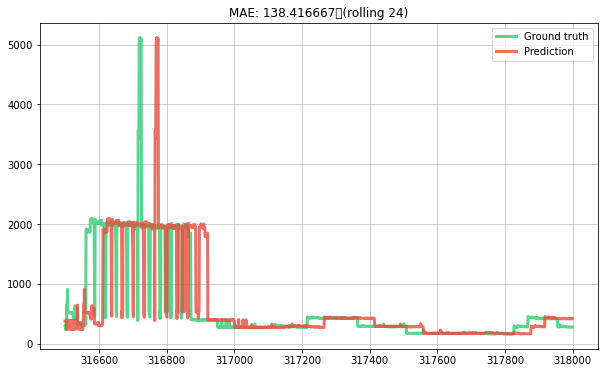

In [91]:
print('Execution time:', elapsed_time, 'seconds')
print('Execution time:', elapsed_time, 'seconds')
print('Execution time:', elapsed_time, 'seconds')
ax.set_title(metric)  #318000
ax.set_title(metric)
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates[316500::], y_trues[316500::], lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates[316500::], y_preds[316500::], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)